In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import time
%matplotlib inline


gameid = 2022090800
playid = 56
frameid = 165


routes_df = pd.read_csv('../route_frames.csv')
routes_df['dir_clean'] = routes_df['dir'] * -np.pi / 180 + np.pi/2

coverage_df = pd.read_csv('../coverage_frames.csv')
coverage_df['dir_clean'] = coverage_df['dir'] * -np.pi / 180 + np.pi/2

ball_df = pd.read_csv('../ball_locations.csv')
ball_df = ball_df[['gameId', 'playId', 'x', 'y']]

stacked_df = pd.concat([routes_df, coverage_df])

stacked_df = stacked_df.merge(ball_df, how='left', on=['gameId', 'playId'], suffixes=('', '_ball'))


stacked_df['dis_to_ball'] = np.sqrt((stacked_df.x - stacked_df.x_ball)**2 + (stacked_df.y - stacked_df.y_ball)**2)

testframe = stacked_df[(stacked_df['gameId'] == gameid) & (stacked_df['playId'] == playid) & (stacked_df['frameId'] == frameid)]
testplay = stacked_df[(stacked_df['gameId'] == gameid) & (stacked_df['playId'] == playid)]

In [ ]:
def get_mean(frame: pd.DataFrame) -> np.ndarray:

    mu_array = np.stack([
        (.5 *
        frame['s'] *
        np.cos(frame['dir_clean'])) + frame['x'],
        (.5 *
        frame['s'] *
        np.sin(frame['dir_clean'])) + frame['y']
    ], axis=1)
    
    return mu_array


def get_cov_matricies(frame: pd.DataFrame) -> np.ndarray:    
    
    # player influence hyperparameters
    scaling_fn = lambda x: np.repeat(4, len(x)) # influence radius relation with distance to ball

    speed_ratios = (frame['s'].to_numpy() ** 2) / (18 ** 2)

    distances = frame['dis_to_ball'].to_numpy()
    diagonals = np.stack([
                    np.array(
                        (scaling_fn(distances) + scaling_fn(distances) * speed_ratios) / 2
                    ),
                    np.array(
                        (scaling_fn(distances) - scaling_fn(distances) * speed_ratios) / 2
                    )]
                , axis=1)
        
    scaling_matricies = diagonals[:, None, :] * np.eye(2)

    thetas = frame['dir_clean'].to_numpy()
    rotation_matricies = np.stack([
        np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
        np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
    ], axis=1)

    covariance_matricies = rotation_matricies @ scaling_matricies @ scaling_matricies @ np.transpose(rotation_matricies, (0,2,1))

    return covariance_matricies


def get_bboxes(means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    eigvals, eigvecs = np.linalg.eigh(covariances)

    major_axes = np.sqrt(eigvals[:, 1])
    minor_axes = np.sqrt(eigvals[:, 0])

    thetas = np.arctan2(eigvecs[:, 1, 1], eigvecs[:, 0, 1])

    t = np.tile(np.linspace(0, 2*np.pi, 100), (means.shape[0], 1))

    ellipses_x = np.reshape(major_axes, (means.shape[0],1)) * np.cos(t) 
    ellipses_y = np.reshape(minor_axes, (means.shape[0],1)) * np.sin(t) 
    
    rotation_matricies = np.stack([
        np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
        np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
    ], axis=1)
    
    rotated_ellipses = rotation_matricies @ np.stack([ellipses_x, ellipses_y], axis=1)


    ellipse_x_final = rotated_ellipses[:, 0, :] + np.reshape(means[:, 0], (means.shape[0], 1))
    ellipse_y_final = rotated_ellipses[:, 1, :] + np.reshape(means[:, 1], (means.shape[0], 1))

    bboxes = np.stack([
        np.min(ellipse_x_final, axis=1), 
        np.max(ellipse_x_final, axis=1), 
        np.min(ellipse_y_final, axis=1), 
        np.max(ellipse_y_final, axis=1)
    ], axis=1)

    return bboxes

    
def filter_defender_bboxes(offense: np.ndarray, defense: np.ndarray):
    
    # cartesian product of offense and defense bboxes
    offense_repeated = np.repeat(offense, defense.shape[0], axis=0)
    defense_repeated = np.tile(defense, (offense.shape[0], 1))

    arr = ~(
        (offense_repeated[:,1] < defense_repeated[:,0]) |
        (defense_repeated[:,1] < offense_repeated[:,0]) |
        (offense_repeated[:,3] < defense_repeated[:,2]) |
        (defense_repeated[:,3] < offense_repeated[:,2])
    )
    return arr.reshape((offense.shape[0], defense.shape[0]))


def check_points_in_offense_ellipses(x: np.ndarray, y: np.ndarray, means: np.ndarray, covariances: np.ndarray):

    # would like to have this function work for if means and covariances have an extra dimension
    
    eigvals, eigvecs = np.linalg.eigh(covariances)

    points = np.stack([x, y], axis=1) - means # shift by mean

    major_axes_len = np.sqrt(eigvals[:, 1])
    minor_axes_len = np.sqrt(eigvals[:, 0])

    major_axes_dir = eigvecs[:, :, 1]
    minor_axes_dir = eigvecs[:, :, 0]
    
    transformed_points = np.stack([
            np.diag(points @ major_axes_dir.T) / major_axes_len,
            np.diag(points @ minor_axes_dir.T) / minor_axes_len
        ], axis=1)
    
    return np.sum(transformed_points ** 2, axis=1) <= 1


def check_points_in_defense_ellipses(x: np.ndarray, y: np.ndarray, means: np.ndarray, covariances: np.ndarray, filter_array: np.ndarray):
    
    # need to check each poitn on each defender
    eigvals, eigvecs = np.linalg.eigh(covariances)

    # shift each point by each mean
    points = np.stack([x, y], axis=1)
    filtered_means = (
        np.tile(
            means, (points.shape[0], 1, 1)
        ).T * filter_array.T
    ).T

    expanded_points = np.transpose(
        np.tile(
            points, (means.shape[0], 1, 1)
        ), (1, 0, 2)
    )

    filtered_points = (
        expanded_points.T * filter_array.T
    ).T
    
    shifted_points = filtered_points - filtered_means

    major_axes_len = np.sqrt(eigvals[:, 1])
    minor_axes_len = np.sqrt(eigvals[:, 0])

    major_axes_dir = eigvecs[:, :, 1]
    minor_axes_dir = eigvecs[:, :, 0]

    filtered_major_evecs = (
        np.transpose(
            np.tile(
                major_axes_dir, (points.shape[0], 1, 1)
            )
        ,(2, 1, 0)) * filter_array.T
    ).T

    filtered_minor_evecs = (
        np.transpose(
            np.tile(
                minor_axes_dir, (points.shape[0], 1, 1)
            )
        ,(2, 1, 0)) * filter_array.T
    ).T
    
    transformed_points = np.stack([
        np.diagonal(
            shifted_points @ np.transpose(
                filtered_major_evecs, (0, 2, 1)
            ), axis1=1, axis2=2
        ) / major_axes_len,
        np.diagonal(
            shifted_points @ np.transpose(
                filtered_minor_evecs, (0, 2, 1)
            ), axis1=1, axis2=2
        ) / minor_axes_len,
    ], axis=1)

    return np.any((np.sum(transformed_points ** 2, axis=1) <= 1) & filter_array, axis=1)


def get_bbox_areas(bboxes):
    return (bboxes[:, 1] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 2]) # xmax - xmin * ymax - ymin



def get_openness(frame: pd.DataFrame):
    offense = frame[frame['wasRunningRoute'] == 1].copy()
    defense = frame[frame['wasRunningRoute'].isna()].copy()

    # mean and covariance matricies for offense
    offense_means = get_mean(offense) # n, 2, 1
    offense_covs = get_cov_matricies(offense) # n, 2, 2

    # mean and covariance matricies for defense
    defense_means = get_mean(defense) 
    defense_covs = get_cov_matricies(defense)

    offense_bboxes = get_bboxes(offense_means, offense_covs)
    defense_bboxes = get_bboxes(defense_means, defense_covs)

    offense_bbox_areas = get_bbox_areas(offense_bboxes)

    # create a search grid for each offense bbox
    n = 50
    search_spaces = np.array([np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n)) for xmin, xmax, ymin, ymax in offense_bboxes])


    filter_arr = filter_defender_bboxes(offense_bboxes, defense_bboxes)


    # create counts array for each offensive player initialized at zero
    counts = np.zeros(offense.shape[0])

    # iterate over indecies for search spaces
    for i in range(n):
        for j in range(n):
            
            x_points = search_spaces[:, 0, i, j]
            y_points = search_spaces[:, 1, i, j]

            in_offense_ellipses = check_points_in_offense_ellipses(
                x_points, y_points, offense_means, offense_covs
            )

            in_any_defense_ellipses = check_points_in_defense_ellipses(
                x_points, y_points, defense_means, defense_covs, filter_arr
            )
            

            counts += (in_offense_ellipses) & (in_any_defense_ellipses)

    intersection_areas = offense_bbox_areas * (counts / n ** 2)

    return 1 - (intersection_areas / offense_bbox_areas)


get_openness(testframe)

array([0.9896, 0.7624, 0.5332, 0.7496])

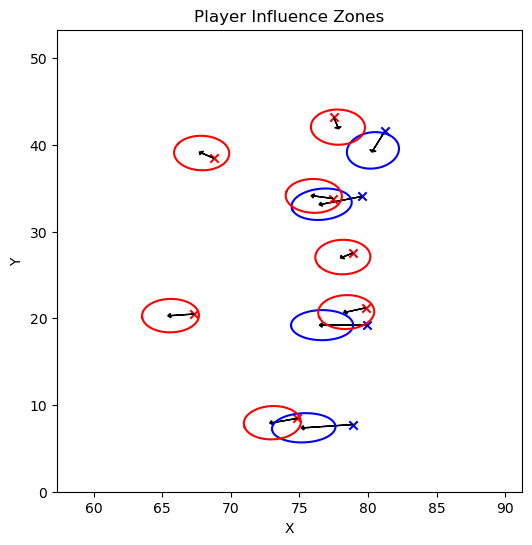

In [10]:
def plot_frame(play_df: pd.DataFrame, frame):
    frame_df = play_df[play_df['frameId'] == frame]
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Player Influence Zones')
    ax.set_ylim(0, 53.3)
    ax.set_xlim(frame_df['x'].min() - 10, frame_df['x'].max() + 10)

    means = get_mean(frame_df)
    covs = get_cov_matricies(frame_df)
    
    eigvals, eigvecs = np.linalg.eigh(covs)

    major_axes = np.sqrt(eigvals[:, 1])
    minor_axes = np.sqrt(eigvals[:, 0])

    thetas = np.arctan2(eigvecs[:, 1, 1], eigvecs[:, 0, 1])

    t = np.tile(np.linspace(0, 2*np.pi, 100), (means.shape[0], 1))

    ellipses_x = np.reshape(major_axes, (means.shape[0], 1)) * np.cos(t) 
    ellipses_y = np.reshape(minor_axes, (means.shape[0], 1)) * np.sin(t) 
    
    rotation_matricies = np.stack([
        np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
        np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
    ], axis=1)
    
    rotated_ellipses = rotation_matricies @ np.stack([ellipses_x, ellipses_y], axis=1)


    ellipse_x_final = rotated_ellipses[:, 0, :] + np.reshape(means[:, 0], (means.shape[0], 1))
    ellipse_y_final = rotated_ellipses[:, 1, :] + np.reshape(means[:, 1], (means.shape[0], 1))

    colors = ['blue', 'red']


    for i, (ellipse_x, ellipse_y) in enumerate(zip(ellipse_x_final, ellipse_y_final)):
        ax.plot(ellipse_x, ellipse_y, color=colors[pd.isna(frame_df.iloc[i].wasRunningRoute)])
        ax.scatter(frame_df.iloc[i].x, frame_df.iloc[i].y, color=colors[pd.isna(frame_df.iloc[i].wasRunningRoute)], marker='x')
        ax.arrow(frame_df.iloc[i].x, frame_df.iloc[i].y, means[i, 0] - frame_df.iloc[i].x, means[i, 1] - frame_df.iloc[i].y, head_width = .5, head_length=.2, color='black')


    return 

frameids = sorted(testplay.frameId.unique())


plot_frame(testplay, frameid)

MovieWriter ffmpeg unavailable; using Pillow instead.


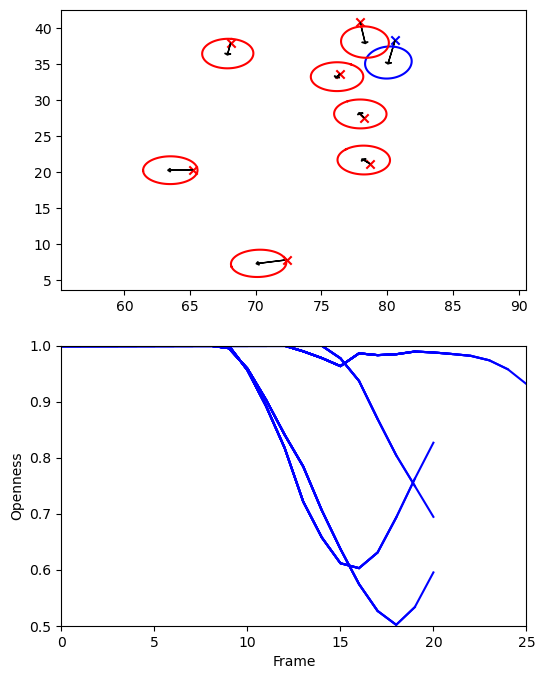

In [11]:

def animate_play(play_df: pd.DataFrame):
    frameid_list = sorted(play_df['frameId'].unique())

    fig, axes = plt.subplots(nrows=2, figsize=(6,8))
    axes[0].set_xlabel('X')
    axes[0].set_ylabel('Y')
    axes[0].set_title('Player Influence Zones')
    axes[0].set_ylim(0, 53.3)

    axes[1].set_xlabel('Frame')
    axes[1].set_ylabel('Openness')
    axes[1].set_ylim((.5, 1))
    axes[1].set_xlim((0, len(frameid_list)))


    colors = ['blue', 'red']
    open_arrs = [[], [], [], []]

    def update(frame):
        frame_df = play_df[play_df['frameId'] == frameid_list[frame]]

        axes[0].clear()
        axes[0].set_xlim(frame_df['x'].min() - 10, frame_df['x'].max() + 10)

        means = get_mean(frame_df)
        covs = get_cov_matricies(frame_df)
        
        eigvals, eigvecs = np.linalg.eigh(covs)

        major_axes = np.sqrt(eigvals[:, 1])
        minor_axes = np.sqrt(eigvals[:, 0])

        thetas = np.arctan2(eigvecs[:, 1, 1], eigvecs[:, 0, 1])

        t = np.tile(np.linspace(0, 2*np.pi, 100), (means.shape[0], 1))

        ellipses_x = np.reshape(major_axes, (means.shape[0], 1)) * np.cos(t) 
        ellipses_y = np.reshape(minor_axes, (means.shape[0], 1)) * np.sin(t) 
        
        rotation_matricies = np.stack([
            np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
            np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
        ], axis=1)
        
        rotated_ellipses = rotation_matricies @ np.stack([ellipses_x, ellipses_y], axis=1)


        ellipse_x_final = rotated_ellipses[:, 0, :] + np.reshape(means[:, 0], (means.shape[0], 1))
        ellipse_y_final = rotated_ellipses[:, 1, :] + np.reshape(means[:, 1], (means.shape[0], 1))



        for i, (ellipse_x, ellipse_y) in enumerate(zip(ellipse_x_final, ellipse_y_final)):
            axes[0].plot(ellipse_x, ellipse_y, color=colors[pd.isna(frame_df.iloc[i].wasRunningRoute)])
            axes[0].scatter(frame_df.iloc[i].x, frame_df.iloc[i].y, color=colors[pd.isna(frame_df.iloc[i].wasRunningRoute)], marker='x')
            axes[0].arrow(frame_df.iloc[i].x, frame_df.iloc[i].y, means[i, 0] - frame_df.iloc[i].x, means[i, 1] - frame_df.iloc[i].y, head_width = .5, head_length=.2, color='black')

        open_arr = get_openness(frame_df)


        for i, open in enumerate(open_arr):
            open_arrs[i] += [open]


            
            axes[1].plot(range(len(open_arrs[i])), open_arrs[i], color='blue')

        

        return 
    
    anim = animation.FuncAnimation(fig, update, frames=len(frameid_list), interval=150)
    anim.save('anim.gif')
    return 


animate_play(testplay)


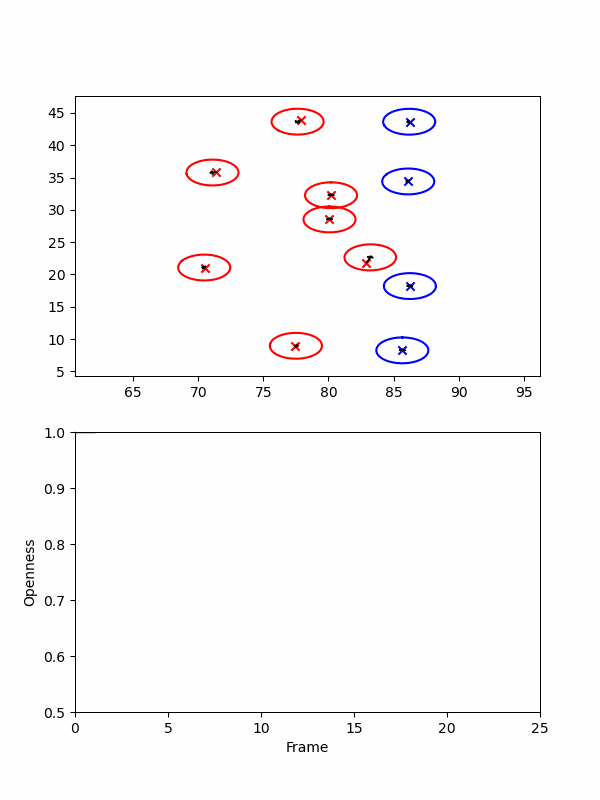

In [5]:
from IPython.display import display, Image

# Display a GIF file
display(Image(filename="anim.gif"))

In [6]:
def get_mean(frame: pd.DataFrame) -> np.ndarray:

    mu_array = np.stack([
        (.5 *
        frame['s'] *
        np.cos(frame['dir_clean'])) + frame['x'],
        (.5 *
        frame['s'] *
        np.sin(frame['dir_clean'])) + frame['y']
    ], axis=1)
    
    return mu_array


def get_cov_matricies(frame: pd.DataFrame) -> np.ndarray:    
    
    # player influence hyperparameters
    scaling_fn = lambda x: np.repeat(4, len(x)) # influence radius relation with distance to ball

    speed_ratios = (frame['s'].to_numpy() ** 2) / (18 ** 2)

    distances = frame['dis_to_ball'].to_numpy()
    diagonals = np.stack([
                    np.array(
                        (scaling_fn(distances) + scaling_fn(distances) * speed_ratios) / 2
                    ),
                    np.array(
                        (scaling_fn(distances) - scaling_fn(distances) * speed_ratios) / 2
                    )]
                , axis=1)
        
    scaling_matricies = diagonals[:, None, :] * np.eye(2)

    thetas = frame['dir_clean'].to_numpy()
    rotation_matricies = np.stack([
        np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
        np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
    ], axis=1)

    covariance_matricies = rotation_matricies @ scaling_matricies @ scaling_matricies @ np.transpose(rotation_matricies, (0,2,1))

    return covariance_matricies


def get_bboxes(means: np.ndarray, covariances: np.ndarray) -> np.ndarray:
    eigvals, eigvecs = np.linalg.eigh(covariances)

    major_axes = np.sqrt(eigvals[:, 1])
    minor_axes = np.sqrt(eigvals[:, 0])

    thetas = np.arctan2(eigvecs[:, 1, 1], eigvecs[:, 0, 1])

    t = np.tile(np.linspace(0, 2*np.pi, 100), (means.shape[0], 1))

    ellipses_x = np.reshape(major_axes, (means.shape[0],1)) * np.cos(t) 
    ellipses_y = np.reshape(minor_axes, (means.shape[0],1)) * np.sin(t) 
    
    rotation_matricies = np.stack([
        np.stack([np.cos(thetas), -np.sin(thetas)], axis=1),
        np.stack([np.sin(thetas), np.cos(thetas)], axis=1)
    ], axis=1)
    
    rotated_ellipses = rotation_matricies @ np.stack([ellipses_x, ellipses_y], axis=1)


    ellipse_x_final = rotated_ellipses[:, 0, :] + np.reshape(means[:, 0], (means.shape[0], 1))
    ellipse_y_final = rotated_ellipses[:, 1, :] + np.reshape(means[:, 1], (means.shape[0], 1))

    bboxes = np.stack([
        np.min(ellipse_x_final, axis=1), 
        np.max(ellipse_x_final, axis=1), 
        np.min(ellipse_y_final, axis=1), 
        np.max(ellipse_y_final, axis=1)
    ], axis=1)

    return bboxes

    
def filter_defender_bboxes(offense: np.ndarray, defense: np.ndarray):
    
    # cartesian product of offense and defense bboxes
    offense_repeated = np.repeat(offense, defense.shape[0], axis=0)
    defense_repeated = np.tile(defense, (offense.shape[0], 1))

    arr = ~(
        (offense_repeated[:,1] < defense_repeated[:,0]) |
        (defense_repeated[:,1] < offense_repeated[:,0]) |
        (offense_repeated[:,3] < defense_repeated[:,2]) |
        (defense_repeated[:,3] < offense_repeated[:,2])
    )
    return arr.reshape((offense.shape[0], defense.shape[0]))


def check_points_in_offense_ellipses(x: np.ndarray, y: np.ndarray, means: np.ndarray, covariances: np.ndarray):

    # would like to have this function work for if means and covariances have an extra dimension
    
    eigvals, eigvecs = np.linalg.eigh(covariances)

    points = np.stack([x, y], axis=1) - means # shift by mean

    major_axes_len = np.sqrt(eigvals[:, 1])
    minor_axes_len = np.sqrt(eigvals[:, 0])

    major_axes_dir = eigvecs[:, :, 1]
    minor_axes_dir = eigvecs[:, :, 0]
    
    transformed_points = np.stack([
            np.diag(points @ major_axes_dir.T) / major_axes_len,
            np.diag(points @ minor_axes_dir.T) / minor_axes_len
        ], axis=1)
    
    return np.sum(transformed_points ** 2, axis=1) <= 1


def check_points_in_defense_ellipses(x: np.ndarray, y: np.ndarray, means: np.ndarray, covariances: np.ndarray, filter_array: np.ndarray):
    
    # need to check each poitn on each defender
    eigvals, eigvecs = np.linalg.eigh(covariances)

    # shift each point by each mean
    points = np.stack([x, y], axis=1)
    filtered_means = (
        np.tile(
            means, (points.shape[0], 1, 1)
        ).T * filter_array.T
    ).T

    expanded_points = np.transpose(
        np.tile(
            points, (means.shape[0], 1, 1)
        ), (1, 0, 2)
    )

    filtered_points = (
        expanded_points.T * filter_array.T
    ).T
    
    shifted_points = filtered_points - filtered_means

    major_axes_len = np.sqrt(eigvals[:, 1])
    minor_axes_len = np.sqrt(eigvals[:, 0])

    major_axes_dir = eigvecs[:, :, 1]
    minor_axes_dir = eigvecs[:, :, 0]

    filtered_major_evecs = (
        np.transpose(
            np.tile(
                major_axes_dir, (points.shape[0], 1, 1)
            )
        ,(2, 1, 0)) * filter_array.T
    ).T

    filtered_minor_evecs = (
        np.transpose(
            np.tile(
                minor_axes_dir, (points.shape[0], 1, 1)
            )
        ,(2, 1, 0)) * filter_array.T
    ).T
    
    transformed_points = np.stack([
        np.diagonal(
            shifted_points @ np.transpose(
                filtered_major_evecs, (0, 2, 1)
            ), axis1=1, axis2=2
        ) / major_axes_len,
        np.diagonal(
            shifted_points @ np.transpose(
                filtered_minor_evecs, (0, 2, 1)
            ), axis1=1, axis2=2
        ) / minor_axes_len,
    ], axis=1)

    return np.any((np.sum(transformed_points ** 2, axis=1) <= 1) & filter_array, axis=1)


def get_bbox_areas(bboxes):
    return (bboxes[:, 1] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 2]) # xmax - xmin * ymax - ymin



def get_openness(frame: pd.DataFrame):
    frame['openness'] = np.NaN
    offense = frame[frame['wasRunningRoute'] == 1].copy()
    defense = frame[frame['wasRunningRoute'].isna()].copy()

    if offense.shape[0] == 0:
        return
        

    # mean and covariance matricies for offense
    offense_means = get_mean(offense) # n, 2, 1
    offense_covs = get_cov_matricies(offense) # n, 2, 2

    # mean and covariance matricies for defense
    defense_means = get_mean(defense) 
    defense_covs = get_cov_matricies(defense)

    offense_bboxes = get_bboxes(offense_means, offense_covs)
    defense_bboxes = get_bboxes(defense_means, defense_covs)

    offense_bbox_areas = get_bbox_areas(offense_bboxes)

    # create a search grid for each offense bbox
    n = 50
    search_spaces = np.array([np.meshgrid(np.linspace(xmin, xmax, n), np.linspace(ymin, ymax, n)) for xmin, xmax, ymin, ymax in offense_bboxes])

    filter_arr = filter_defender_bboxes(offense_bboxes, defense_bboxes)


    # create counts array for each offensive player initialized at zero
    counts = np.zeros(offense.shape[0])

    # iterate over indecies for search spaces
    for i in range(n):
        for j in range(n):
            
            x_points = search_spaces[:, 0, i, j]
            y_points = search_spaces[:, 1, i, j]

            in_offense_ellipses = check_points_in_offense_ellipses(
                x_points, y_points, offense_means, offense_covs
            )

            in_any_defense_ellipses = check_points_in_defense_ellipses(
                x_points, y_points, defense_means, defense_covs, filter_arr
            )
            

            counts += (in_offense_ellipses) & (in_any_defense_ellipses)

    intersection_areas = offense_bbox_areas * (counts / n ** 2)


    frame.loc[frame['wasRunningRoute'] == 1, 'openness'] = 1 - (intersection_areas / offense_bbox_areas)

    return frame.copy()

#get_openness(testframe)

In [7]:
import dask.dataframe as dd
ddf = dd.from_pandas(stacked_df, npartitions=10)
df = ddf.groupby(['gameId', 'playId', 'frameId']).apply(get_openness, meta=stacked_df).compute()

ValueError: The columns in the computed data do not match the columns in the provided metadata
  Extra:   ['openness']
  Missing: []

In [ ]:
def testfn(x):
    print(x.to_numpy())
    print('\n')
    return x

openness = (
    stacked_df
    [['gameId', 'playId', 'frameId', 'wasRunningRoute', 'x', 'y', 's', 'dir_clean', 'dis_to_ball']]
    .groupby(['gameId', 'playId', 'frameId'])
    .transform(testfn)
)


(11,)


(11,)


(11,)


(11,)


(11,)


(11,)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(11, 6)


(8, 6)


(8, 6)


(8, 6)


(8, 6)


(8, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(10, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(7, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(12, 6)


(1

,wasRunningRoute,x,y,s,dir_clean,dis_to_ball
0,1.0,86.23,43.65,0.05,-2.831448,14.000946
1,1.0,86.20,43.64,0.23,-2.912431,13.988713
2,1.0,86.15,43.64,0.66,-3.000396,13.985084
3,1.0,86.05,43.63,1.16,-3.060958,13.968381
4,1.0,85.89,43.62,1.81,-3.080855,13.949114
...,...,...,...,...,...,...
457353,NaN,54.40,15.33,5.95,-3.290993,17.618650
457354,NaN,53.83,15.43,5.74,-3.298149,17.874029
457355,NaN,53.28,15.53,5.45,-3.316824,18.131807
457356,NaN,52.77,15.63,5.09,-3.340037,18.377228


In [ ]:
test = (
    stacked_df
    .groupby(['gameId', 'playId', 'frameId']).swifter.apply(
        get_openness
    )
)

AttributeError: 'DataFrameGroupBy' object has no attribute 'swifter'